# Veri Seti Hazırlığı 

Bu kod, belirli sınıflardan alınan resim verilerini işleyip, eğitim ve test setlerine ayırarak derin öğrenme modeline hazırlamak için kullanılır.

## Adımlar:

1. **Veri Setini Yükleme**:
   - `selected_classes` listesinde belirtilen 10 farklı sınıf (örneğin: 'collie', 'dolphin', vb.) adıyla her bir sınıfın resimlerine ulaşılır.
   - Her sınıf için en fazla 650 resim alınır ve işlenir.

2. **Resimlerin Boyutlandırılması ve Normalizasyon**:
   - Resimler, `(128, 128)` boyutlarına yeniden boyutlandırılır ve 0-255 arasındaki renk değerleri 0 ile 1 arasına normalize edilir.
   
3. **Eğitim ve Test Setlerine Bölme**:
   - `train_test_split` fonksiyonu kullanılarak, her sınıftan elde edilen resimler eğitim (yaklaşık %80) ve test (yaklaşık %20) setlerine ayrılır.

4. **Resimlerin Kaydedilmesi**:
   - Eğitim ve test setlerine ait resimler, her sınıf için ayrı dizinlerde düzenlenir ve kaydedilir.
   - Görüntüler, ilgili `train` ve `test` dizinlerine sırasıyla kaydedilir.

5. **Veri Seti Hazırlığı**:
   - Eğitim verileri (`train_X` ve `train_y`) NumPy dizilerine dönüştürülür ve derin öğrenme modelinin eğitimine uygun hale getirilir.
   - Etiketler (`train_y` ve `test_y`), `to_categorical` fonksiyonu kullanılarak one-hot encoding formatına dönüştürülür.

## Veri Kümesinin Yapısı:
- **Eğitim Seti**: Her sınıftan alınan resimlerin %80'i eğitim için kullanılır.
- **Test Seti**: Her sınıftan alınan resimlerin %20'si test için ayrılır.

Sonuç olarak, modelin eğitimi için uygun eğitim ve test setleri hazırlanır. Eğitim seti ile model eğitilirken, test seti ile modelin doğruluğu ve kaybı ölçülür. Bu adımlar, daha sonra derin öğrenme modelinin performansını değerlendirmek için kullanılır.


In [41]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
 
np.random.seed(2)
 
selected_classes = ['collie', 'dolphin', 'elephant', 'fox', 'moose',
                    'rabbit', 'sheep', 'squirrel', 'giant+panda', 'polar+bear']
 
dataset_path = "../input/animals-with-attributes-2/Animals_with_Attributes2/JPEGImages"
output_path = "./ProcessedImages"
 
os.makedirs(output_path, exist_ok=True)
 
image_size = (128, 128)
test_size = 0.2
 
train_dir = os.path.join(output_path, "train")
test_dir = os.path.join(output_path, "test")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
 
train_X, train_y, test_X, test_y = [], [], [], []
label_map = {class_name: idx for idx, class_name in enumerate(selected_classes)}
 
for class_name in selected_classes:
    class_path = os.path.join(dataset_path, class_name)
    images = os.listdir(class_path)[:650]   

    class_X, class_y = [], []

    for image_name in images:
        image_path = os.path.join(class_path, image_name)
        img = cv2.imread(image_path)
 
        if img is not None: 
            img_resized = cv2.resize(img, image_size)
            img_normalized = img_resized / 255.0
            class_X.append(img_normalized)
            class_y.append(label_map[class_name])
 
    class_train_X, class_test_X, class_train_y, class_test_y = train_test_split(
        class_X, class_y, test_size=test_size, random_state=42)

    train_X.extend(class_train_X)
    train_y.extend(class_train_y)
    test_X.extend(class_test_X)
    test_y.extend(class_test_y)
 
    train_class_dir = os.path.join(train_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

    for idx, img in enumerate(class_train_X):
        output_image_path = os.path.join(train_class_dir, f"{class_name}_train_{idx}.jpg")
        cv2.imwrite(output_image_path, (img * 255).astype(np.uint8))

    for idx, img in enumerate(class_test_X):
        output_image_path = os.path.join(test_class_dir, f"{class_name}_test_{idx}.jpg")
        cv2.imwrite(output_image_path, (img * 255).astype(np.uint8))
 
train_X = np.array(train_X)
train_y = np.array(train_y)
test_X = np.array(test_X)
test_y = np.array(test_y)
 
print("Eğitim Veri Seti Şekli:", train_X.shape)
print("Test Veri Seti Şekli:", test_X.shape)
 
train_y = to_categorical(train_y, num_classes=len(selected_classes))
test_y = to_categorical(test_y, num_classes=len(selected_classes))


Eğitim Veri Seti Şekli: (5200, 128, 128, 3)
Test Veri Seti Şekli: (1300, 128, 128, 3)


### Derin Sinir Ağı Modeli: CNN Mimarisi

Bu model, 128x128 boyutlarında renkli görüntülerin sınıflandırılması için tasarlanmış bir Convolutional Neural Network (CNN) mimarisidir. Model aşağıdaki katmanlardan oluşmaktadır:

1. **Giriş Katmanı:**
   - Girdi boyutu `(128, 128, 3)` olarak tanımlanmıştır (128x128 çözünürlükte, RGB formatında görüntüler).

2. **Convolutional ve Pooling Katmanları:**
   - **1. Convolution Bloğu:**
     - 2 adet 32 filtreli, `(5x5)` kernel boyutuna sahip Conv2D katmanı (ReLU aktivasyon fonksiyonu ve `Same` padding).
     - Bir MaxPooling katmanı `(2x2)` havuzlama boyutunda.
     - %25 Dropout uygulanarak overfitting engellenir.
   - **2. Convolution Bloğu:**
     - 2 adet 64 filtreli, `(3x3)` kernel boyutuna sahip Conv2D katmanı (ReLU aktivasyon fonksiyonu ve `Same` padding).
     - Bir MaxPooling katmanı `(2x2)` havuzlama boyutunda.
     - %25 Dropout uygulanır.

3. **Tam Bağlantılı (Fully Connected) Katmanlar:**
   - Veriler bir `Flatten` katmanı ile düzleştirilir.
   - 256 nöronlu bir Dense katmanı (ReLU aktivasyon fonksiyonu).
   - %50 Dropout uygulanır.
   - Sınıflandırma için `softmax` aktivasyon fonksiyonuna sahip bir Dense katmanı bulunur. Çıkış nöron sayısı, sınıf sayısına (`len(selected_classes)`) eşittir.

4. **Model Özeti:**
   - `model.summary()` kullanılarak modelin katmanları ve parametre sayıları özetlenir.

Bu mimari, derin öğrenme tabanlı sınıflandırma problemleri için oldukça uygun bir yapıya sahiptir ve overfitting'i önlemek için Dropout katmanları içermektedir.


In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, Input
 
model = Sequential([ 
    Input(shape=(128, 128, 3)), 
    Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu'),
    Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),
 
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),
 
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(selected_classes), activation='softmax')  
])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 128, 128, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 128, 128, 32)        │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │      16,777,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,863,530 (64.33 MB)

 Trainable params: 16,863,530 (64.33 MB)

 Non-trainable params: 0 (0.00 B)

### Modelin Derlenmesi: Optimizer ve Kayıp Fonksiyonu

Bu bölümde model, sınıflandırma problemleri için uygun bir şekilde derlenmiştir. Aşağıdaki ayarlar kullanılmıştır:

1. **Optimizer (Optimizasyon Algoritması):**  
   - **RMSprop:** 
     - `learning_rate=0.001`: Öğrenme oranı, modelin parametrelerini güncelleme hızını belirler.
     - `rho=0.9`: Hareketli ortalama için ağırlıklandırma katsayısı.
     - `epsilon=1e-08`: Sayısal kararlılık için küçük bir değer.

2. **Kayıp Fonksiyonu:**  
   - **Categorical Crossentropy:** Çok sınıflı sınıflandırma problemleri için kullanılır. Modelin çıkışındaki olasılık dağılımı ile gerçek dağılım arasındaki farkı hesaplar.

3. **Değerlendirme Metrikleri:**  
   - **Accuracy (Doğruluk):** Modelin doğru sınıflandırma oranını ölçer.
 

In [43]:
from tensorflow.keras.optimizers import RMSprop
 
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08)
 
model.compile(optimizer=optimizer, 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])




### Veri Artırma: `ImageDataGenerator`

Bu bölümde, eğitim veri setini zenginleştirmek ve modelin genelleme yeteneğini artırmak amacıyla veri artırma teknikleri uygulanmıştır. 

#### **Kullanılan Veri Artırma Parametreleri:**
1. **`rotation_range=10`:** 
   - Görüntüler, rastgele olarak ±10 derece arasında döndürülür.
   - Bu, modele farklı açıdaki görüntülere karşı dayanıklılık kazandırır.

2. **`zoom_range=0.1`:**
   - Görüntüler, rastgele olarak %10 oranında yakınlaştırılır veya uzaklaştırılır.
   - Bu, ölçek değişikliklerine karşı modelin genelleme yapmasını sağlar.

3. **`width_shift_range=0.1`:**
   - Görüntüler yatay eksende rastgele olarak %10 oranında kaydırılır.
   - Modelin nesne konumundaki varyasyonlara karşı dayanıklılığı artırılır.

4. **`height_shift_range=0.1`:**
   - Görüntüler dikey eksende rastgele olarak %10 oranında kaydırılır.
   - Model, farklı yüksekliklerdeki nesneleri öğrenme kapasitesine sahip olur.

#### **Veri Artırma İşleminin Uygulanması:**
- **`datagen.fit(train_x)`:**  
  - `ImageDataGenerator`, eğitim verisi üzerinde artırma işlemlerini uygulamak için hazırlanır. Bu adımda veri setinin istatistiksel özellikleri öğrenilir ve artırma işlemleri gerçekleştirilir.

 


In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=10,  
    zoom_range=0.1,     
    width_shift_range=0.1, 
    height_shift_range=0.1  
)
datagen.fit(train_X)



### Model Eğitimi: `model.fit`

Bu bölümde model, eğitim verileri üzerinde optimize edilmiş parametreler ve öğrenme oranı azaltma stratejisi ile eğitilmiştir.

#### **Önemli Parametreler:**

1. **`ReduceLROnPlateau` Callback:**
   - **Amaç:** Eğitim sırasında doğrulama başarımı (`val_accuracy`) iyileşmediğinde öğrenme oranını dinamik olarak azaltarak daha iyi bir optimizasyon yapılmasını sağlar.
   - **Parametreler:**
     - `monitor='val_accuracy'`: Doğrulama doğruluk oranı takip edilir.
     - `patience=3`: Eğer doğrulama başarımı 3 ardışık dönem boyunca iyileşmezse, öğrenme oranı azaltılır.
     - `verbose=1`: İşlemler sırasında bilgi mesajlarının konsola yazdırılmasını sağlar.
     - `factor=0.5`: Öğrenme oranını %50 oranında azaltır.
     - `min_lr=0.00001`: Öğrenme oranı bu değerin altına düşmez.

2. **Eğitim Parametreleri:**
   - **`epochs=30`:** Model 30 dönem boyunca eğitilir.
   - **`batch_size=86`:** Her eğitim adımında 86 görüntü işlenir.

3. **Model Eğitimi:**
   - **`datagen.flow(train_X, train_y, batch_size=batch_size)`:** Veri artırma işlemi uygulanmış eğitim verileri modelin eğitimine sağlanır.
   - **`validation_data=(test_X, test_y)`:** Doğrulama verisi, modelin performansını değerlendirmek için kullanılır.
   - **`callbacks=[learning_rate_reduction]`:** `ReduceLROnPlateau` callback'i, öğrenme oranını dinamik olarak kontrol eder.

 


In [45]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-5)

 
epochs = 30
batch_size = 86

history = model.fit(datagen.flow(train_X, train_y, batch_size=batch_size),
                    epochs=epochs, 
                    validation_data=(test_X, test_y),
                    verbose=2, 
                    callbacks=[learning_rate_reduction]
                   )


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


61/61 - 21s - 352ms/step - accuracy: 0.1723 - loss: 2.4044 - val_accuracy: 0.1892 - val_loss: 2.2041 - learning_rate: 0.0010
Epoch 2/30
61/61 - 17s - 280ms/step - accuracy: 0.2379 - loss: 2.1084 - val_accuracy: 0.3385 - val_loss: 1.8804 - learning_rate: 0.0010
Epoch 3/30
61/61 - 17s - 281ms/step - accuracy: 0.3360 - loss: 1.9066 - val_accuracy: 0.4408 - val_loss: 1.5903 - learning_rate: 0.0010
Epoch 4/30
61/61 - 17s - 279ms/step - accuracy: 0.3917 - loss: 1.7581 - val_accuracy: 0.4392 - val_loss: 1.5708 - learning_rate: 0.0010
Epoch 5/30
61/61 - 17s - 281ms/step - accuracy: 0.4333 - loss: 1.6218 - val_accuracy: 0.4708 - val_loss: 1.4594 - learning_rate: 0.0010
Epoch 6/30
61/61 - 17s - 280ms/step - accuracy: 0.4579 - loss: 1.5849 - val_accuracy: 0.5369 - val_loss: 1.4021 - learning_rate: 0.0010
Epoch 7/30
61/61 - 17s - 283ms/step - accuracy: 0.4760 - loss: 1.5137 - val_accuracy: 0.5369 - val_loss: 1.3614 - learning_rate: 0.0010
Epoch 8/30
61/61 - 17s - 279ms/step - accuracy: 0.4937 - lo

### Model Kaydetme

Eğitim tamamlandıktan sonra, modelin tüm ağırlıkları, yapısı ve optimizer'ı kaydedilerek gelecekteki kullanımlar için depolanır. Bu işlem, modelin tekrar eğitilmeden kullanılmasına olanak tanır.


In [46]:
model.save("/kaggle/working/model.h5")   
print("Model başarıyla kaydedildi!")

Model başarıyla kaydedildi!


### Model Değerlendirmesi: Test Seti Üzerinde Performans

Modelin test seti üzerindeki başarımını değerlendirmek için `evaluate` fonksiyonu kullanılır. Bu, modelin test verileriyle ne kadar iyi performans gösterdiğini ölçmek için kullanılır.


In [47]:
original_score = model.evaluate(test_X, test_y, verbose=0)
print(f"Orijinal test seti doğruluk oranı: {original_score[1]:.4f}")

Orijinal test seti doğruluk oranı: 0.6800


### Model Eğitim Süreci: Kayıp ve Doğruluk Grafikleri

Modelin eğitim süreci sırasında kayıp ve doğruluk metriklerini görselleştirerek, modelin öğrenme sürecini değerlendirebiliriz. Aşağıda, eğitim ve doğrulama kayıpları ile doğruluklarının nasıl görselleştirildiği gösterilmektedir.


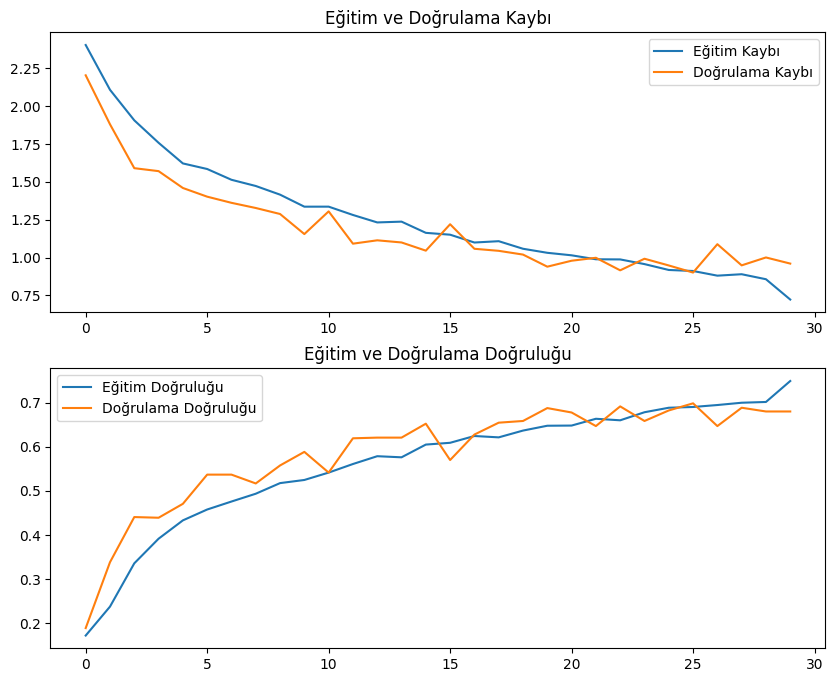

In [48]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,1, figsize=(10,8))

ax[0].plot(history.history['loss'], label="Eğitim Kaybı")
ax[0].plot(history.history['val_loss'], label="Doğrulama Kaybı")
ax[0].legend()
ax[0].set_title("Eğitim ve Doğrulama Kaybı")

ax[1].plot(history.history['accuracy'], label="Eğitim Doğruluğu")
ax[1].plot(history.history['val_accuracy'], label="Doğrulama Doğruluğu")
ax[1].legend()
ax[1].set_title("Eğitim ve Doğrulama Doğruluğu")

plt.show()



Grafiklerde eğitim ve doğrulama kayıplarının azaldığı, doğruluk oranlarının ise arttığı görülmektedir. 

- **Eğitim ve Doğrulama Kaybı**: Kayıplar genelde düşüş göstermiş, ancak doğrulama kaybında küçük dalgalanmalar var.
- **Eğitim ve Doğrulama Doğruluğu**: Doğruluk oranları düzenli olarak artmış ve eğitim ile doğrulama doğrulukları birbirine yakın seyretmiş. Model overfitting göstermemiş.

Genel olarak, modelin performansı olumlu değerlendirilmiştir.


### Model Performansı: Confusion Matrix (Karmaşa Matrisi)

Modelin tahmin performansını daha ayrıntılı incelemek için **Confusion Matrix** (Karmaşa Matrisi) kullanılır. Bu matris, modelin doğru ve yanlış sınıflandırmalarını görselleştirir ve her sınıf için doğru ve yanlış tahminlerin sayısını gösterir.


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


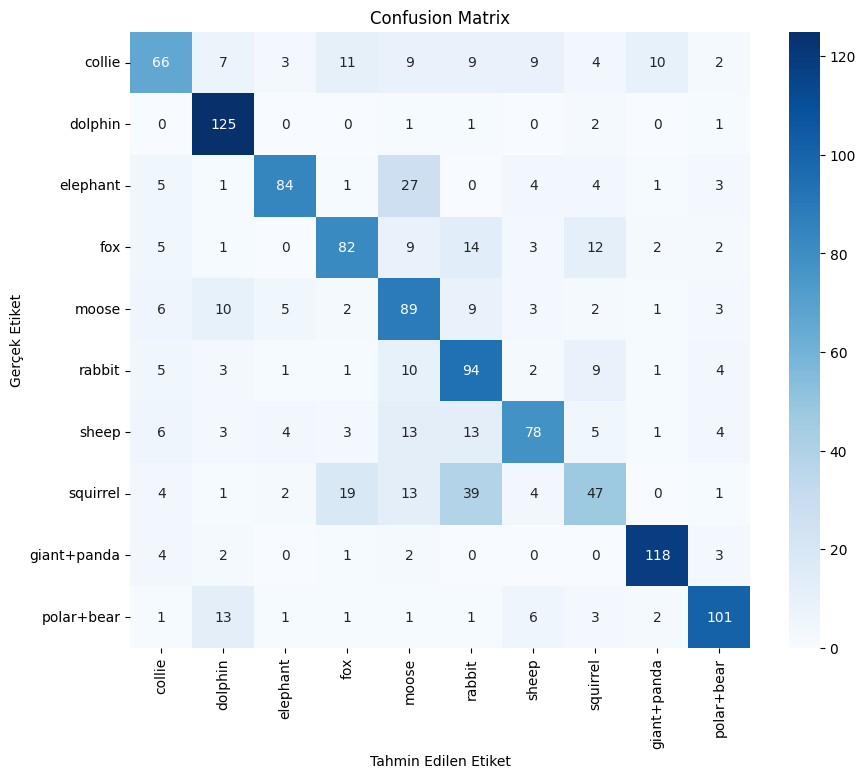

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = np.argmax(model.predict(test_X), axis=1)
Y_true = np.argmax(test_y, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=selected_classes, yticklabels=selected_classes)
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.title("Confusion Matrix")
plt.show()



- Modelin en iyi performans gösterdiği sınıflar: "dolphin", "giant-panda", ve "polar-bear" sınıfları yüksek doğru sınıflandırma oranlarına sahip.
- Modelin karıştırmaya meyilli olduğu sınıflar: Özellikle "squirrel" ve "elephant" gibi sınıflar, diğer kategorilerle sıkça karışmış.

### Manipüle Edilmiş Görüntüler Oluşturma ve Kaydetme

Bu kod, test setindeki orijinal görüntülere mor ışık efekti ekleyerek manipüle edilmiş yeni görüntüler oluşturur. Manipüle edilmiş görüntüler, her sınıf için yeni bir klasörde kaydedilir ve numpy array formatında bir listeye eklenir.


In [50]:
import os
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

original_dir = "/kaggle/working/ProcessedImages/test/"
manipulated_dir = "/kaggle/working/ManipulatedImages"

if not os.path.exists(original_dir):
    raise FileNotFoundError(f"Belirtilen klasör mevcut değil: {original_dir}")

os.makedirs(manipulated_dir, exist_ok=True)

def add_purple_light(img, light_factor=1.5): 
    img_array = np.asarray(img) / 255.0   
    img_array[..., 0] = np.clip(img_array[..., 0] * light_factor, 0, 1)   
    img_array[..., 2] = np.clip(img_array[..., 2] * light_factor, 0, 1)  
    manipulated_img = Image.fromarray((img_array * 255).astype('uint8'))
    return manipulated_img

manipulated_test_X = []
test_y = []   

for class_name in os.listdir(original_dir):
    class_path = os.path.join(original_dir, class_name)
    if not os.path.isdir(class_path):  
        continue

    class_output_dir = os.path.join(manipulated_dir, class_name)
    os.makedirs(class_output_dir, exist_ok=True)
    
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        img = Image.open(image_path)
        manipulated_img = add_purple_light(img)
        manipulated_img.save(os.path.join(class_output_dir, image_name))
        manipulated_test_X.append(np.asarray(manipulated_img) / 255.0)  
        test_y.append(class_name)
 
label_encoder = LabelEncoder()
test_y = label_encoder.fit_transform(test_y)
 
manipulated_test_X = np.array(manipulated_test_X)
test_y = np.array(test_y)

test_y = to_categorical(test_y, num_classes=len(label_encoder.classes_))
print(f"Manipüle edilmiş görüntüler '{manipulated_dir}' klasörüne sınıf yapısıyla kaydedildi.")


Manipüle edilmiş görüntüler '/kaggle/working/ManipulatedImages' klasörüne sınıf yapısıyla kaydedildi.


### Manipüle Edilmiş Test Seti Değerlendirmesi

Bu adımda, modelin manipüle edilmiş test seti üzerinde değerlendirme yapıyoruz. Değerlendirme sonucu, kayıp ve doğruluk oranı olarak iki ana metriği içerir.


In [51]:
manipulated_score = model.evaluate(manipulated_test_X, test_y, verbose=0)
print(f"Manipüle edilmiş test seti için Kayıp: {manipulated_score[0]:.4f}, Doğruluk Oranı: {manipulated_score[1]:.4f}")


Manipüle edilmiş test seti için Kayıp: 5.6269, Doğruluk Oranı: 0.1008


#### Manipüle Edilmiş Veri Seti İçin Confusion Matrix

Manipüle edilmiş veri setiyle modelin performansını değerlendirmek için confusion matrix'i şu şekilde oluşturuyoruz:


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


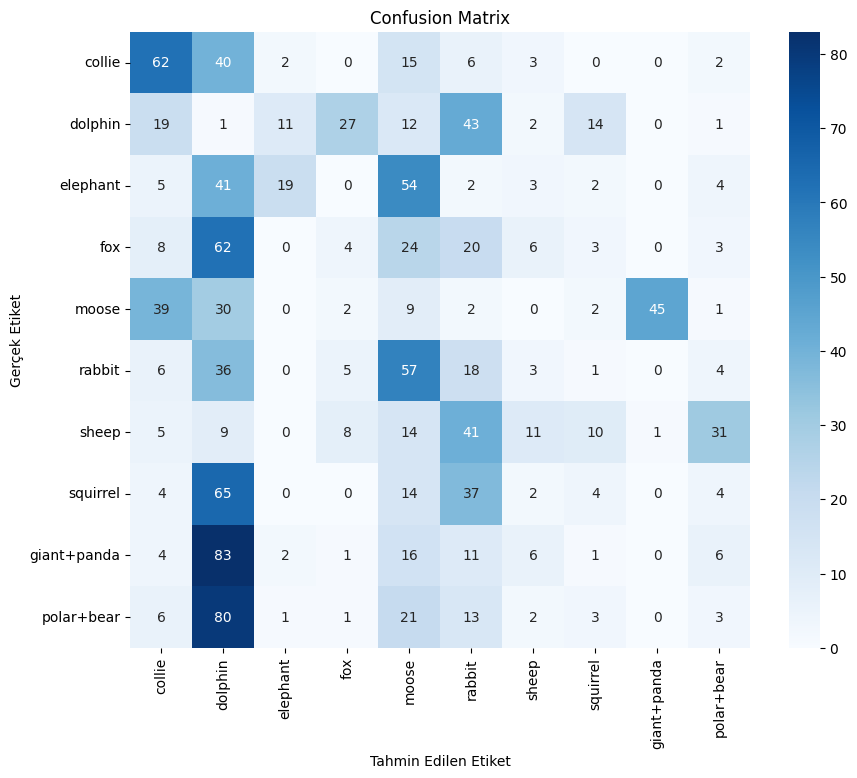

In [52]:
Y_pred = np.argmax(model.predict(manipulated_test_X), axis=1)
Y_true = np.argmax(test_y, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=selected_classes, yticklabels=selected_classes)
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.title("Confusion Matrix")
plt.show()


Bazı sınıflar arasında yoğun bir karışıklık görülmektedir. Özellikle:
- "Polar bear" ve "giant panda" sınıfları sıklıkla "dolphin" olarak sınıflandırılmıştır.
- "Moose" ve "polar bear" arasında da karışıklık belirgindir.

"Collie" ve "elephant" gibi sınıflar nispeten daha iyi performans göstermektedir.
Görseller arasındaki renk değişiklikleri modelin genelleştirme yeteneğini olumsuz etkilemiş gibi görünmektedir.


### Gray World Renk Düzeltme Yöntemi

Bu adımda, Gray World renk düzeltme yöntemini kullanarak manipüle edilmiş test setindeki görüntülere renk düzeltmesi uyguluyoruz. Gray World yöntemi, görüntüdeki tüm renk kanallarının ortalamasını hesaplayarak renk dengesini düzenler.


In [53]:
import os
import numpy as np
from PIL import Image
 
def get_wb_images(images):
    wb_images = []
    for img in images:
        avg_rgb = np.mean(img, axis=(0, 1), keepdims=True)
        gray_world_img = np.clip(img * (avg_rgb.mean() / avg_rgb), 0, 1)
        wb_images.append(gray_world_img)
    return np.array(wb_images)
 
wb_test_X = get_wb_images(manipulated_test_X)
 
gray_world_dir = "GrayWorldImages"
os.makedirs(gray_world_dir, exist_ok=True)
 
for class_name in os.listdir(original_dir):  
    class_path = os.path.join(original_dir, class_name)
    
    if not os.path.isdir(class_path):   
        continue
     
    class_output_dir = os.path.join(gray_world_dir, class_name)
    os.makedirs(class_output_dir, exist_ok=True)
     
    for i, img_array in enumerate(wb_test_X):   
        if i % len(os.listdir(class_path)) == 0:
            img = Image.fromarray((img_array * 255).astype('uint8'))   
            img.save(os.path.join(class_output_dir, f"image_{i}.png"))

print(f"Gray World uygulanmış görüntüler '{gray_world_dir}' klasörüne sınıf yapısıyla kaydedildi.")


Gray World uygulanmış görüntüler 'GrayWorldImages' klasörüne sınıf yapısıyla kaydedildi.


### Gray World Renk Düzeltme Sonuçları

Bu adımda, Gray World renk düzeltme yöntemi uygulanmış test seti üzerinde modelin performansı değerlendirilmektedir. Değerlendirme sonucu, kayıp ve doğruluk oranı gibi iki ana metrik hesaplanır.


In [54]:
wb_score = model.evaluate(wb_test_X, test_y, verbose=0)
print(f"Renk Sabitliği uygulanmış test seti için Kayıp: {wb_score[0]:.4f}, Doğruluk Oranı: {wb_score[1]:.4f}")


Renk Sabitliği uygulanmış test seti için Kayıp: 5.1016, Doğruluk Oranı: 0.1277


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


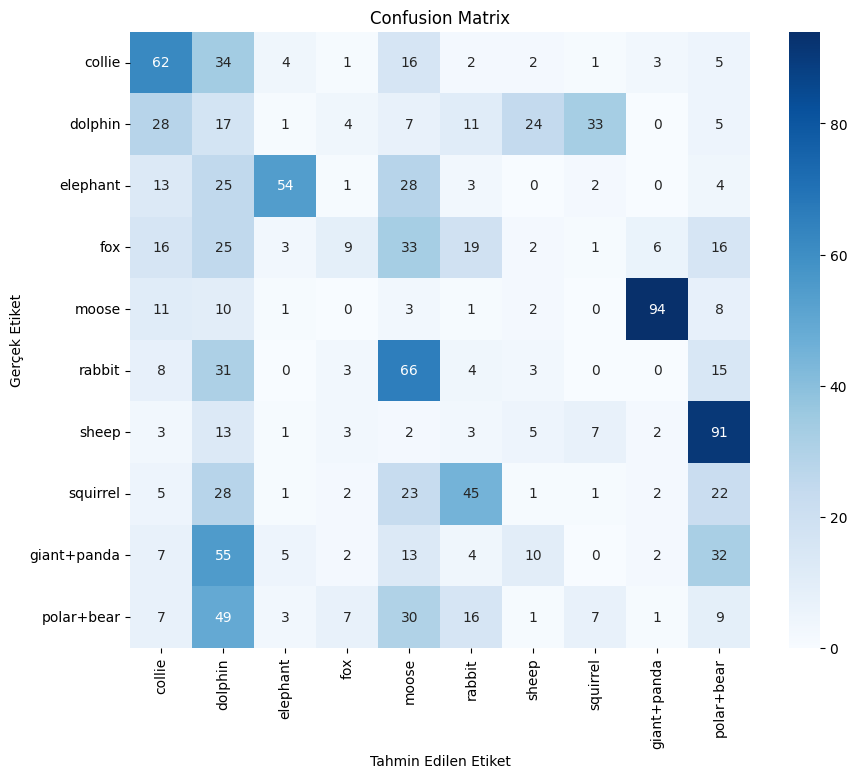

In [55]:
Y_pred = np.argmax(model.predict(wb_test_X), axis=1)
Y_true = np.argmax(test_y, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=selected_classes, yticklabels=selected_classes)
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.title("Confusion Matrix")
plt.show()


  - Hatalı tahminler azalmakla birlikte, bazı sınıflar arasında karışıklık sürmektedir.

### Test Seti Başarı Oranları

Bu adımda, modelin farklı veri setlerinde gösterdiği başarı oranları karşılaştırılmaktadır. Test setlerinin her biri, farklı veri manipülasyon tekniklerine tabi tutulmuş ve modelin bu setler üzerindeki doğruluk oranları değerlendirilmiştir.


In [56]:
print("--- Test Seti Başarı Oranları ---")
print(f"Orijinal test seti doğruluk oranı: {original_score[1]:.4f}")
print(f"Manipüle Edilmiş: {manipulated_score[1]:.4f}")
print(f"Renk Sabitliği Uygulanmış: {wb_score[1]:.4f}")

--- Test Seti Başarı Oranları ---
Orijinal test seti doğruluk oranı: 0.6800
Manipüle Edilmiş: 0.1008
Renk Sabitliği Uygulanmış: 0.1277


Orijinal test setindeki doğruluk oranı %68 iken, manipüle edilmiş test setinde bu oran %10.04'e düşmüştür. Bu, manipülasyonun test setinin doğruluğu üzerinde olumsuz bir etki yarattığını göstermektedir. Ancak, Gray World yöntemi kullanıldığında, doğruluk oranı %12.77'ye yükselmiştir. Bu, Gray World algoritmasının manipüle edilmiş test setindeki verilerin daha doğru bir şekilde işlenmesine yardımcı olduğunu ve doğruluğun bir miktar iyileştirildiğini göstermektedir.

Bu sonuçlar, Gray World yönteminin, manipüle edilmiş test setinde doğruluğu arttırma potansiyeline sahip olduğunu ancak tam olarak orijinal test setinin doğruluğuna ulaşamadığını ortaya koymaktadır. Bu iyileştirme, görüntü işleme ve renk düzeltme tekniklerinin manipüle edilmiş veriler üzerinde önemli bir etkisi olabileceğini göstermektedir.